# SWMM with Python Week 3: Sensitivity Analysis Part 2

Just a reminder of the experiment. We let it rain at 5 in/hr for two hours, then we run experiments of soaking soils using 27 different combinations of Green Ampt parameters. Hopefully we can learn how Green Ampt works without knowing anything about the theories.

Last week, I managed to run 27 simulations and plot the infiltration results in one plot. But the range was too wide, and most of the combination resulted in infiltrating 100% of the rainfall. So I decided to limit the range to a much smaller range to sandy loam, loam and silt loam and learn from the simulation results.

This week is the fun part, we no longer need to worry about the plumbing part of getting the results. Let's learn from the results

I combined all the code in one block from last week to make it easier to run.

In [1]:
from jinja2 import Environment, FileSystemLoader
import logging

def render_input(tmp_folder,tmp_name,  data, out_inp):
    '''
    render an input file using a template.
    tmp_folder: folde where the template inp file is.
    tmp_name: name of the template file
    data: the data to be applied to the template
    out_inp: the inp file with values applied
    '''
    env = Environment(loader=FileSystemLoader(tmp_folder))
    template = env.get_template(tmp_name)
    output_from_parsed_template = template.render(data)
    # to save the results
    with open(out_inp, "w") as fh:
        fh.write(output_from_parsed_template)
        logging.info('inp created:%s' % out_inp)

from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt
def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()


from swmm.output import output as smo
import pandas as pd
import datetime

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_rainfall(out_path, sub_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))

    # get the time sereis from the out file
    values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.RAINFALL, 0, num_steps)
    df = pd.DataFrame({'rainfall': values}, index=timestep)
    return df

def extract_infiltration(out_path, sub_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))

    # get the time sereis from the out file
    values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.INFIL_LOSS, 0, num_steps)
    df = pd.DataFrame({'infil': values}, index=timestep)
    return df

import os

def sensitivity_analysis(tmp_folder, tmp_name, out_folder, suction_list, k_list, imd_list):
    labels = ['l', 'm', 'h']

    dfs = None
    i = 0
    for sl, s in zip(labels, suction_list):
        for kl, k in zip(labels, k_list):
            for imdl, imd in zip(labels, imd_list):
                data = {'suction': s, 'ksat': k, 'imd': imd}
                run_id = '%s_%s_%s' % (sl, kl, imdl)
                out_inp = os.path.join(out_folder, '%s.inp' % run_id)
                out_path = os.path.join(out_folder, '%s.out' % run_id)
                print(out_inp)
                render_input(tmp_folder,tmp_name,  data, out_inp)
                run(out_inp)
                i += 1
                if i == 1:
                    df = extract_rainfall(out_path, 0)
                    dfs = df.copy()

                df = extract_infiltration(out_path, 0)
                dfs[run_id] = df['infil']
    return dfs

# Automation is a major benenfit
The power of writing python scripts is that you can easily reuse the code developed before. With a change of the parameter ranges, we can get our new results within a few minutes. If I've done it mannually, I don't think I have the will to repeat what I did last week with a new set of parameters at this point.

C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_l.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_m.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_h.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_l.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_m.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_h.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_h_l.inp

... SWMM Version 5.3.0.dev0
.

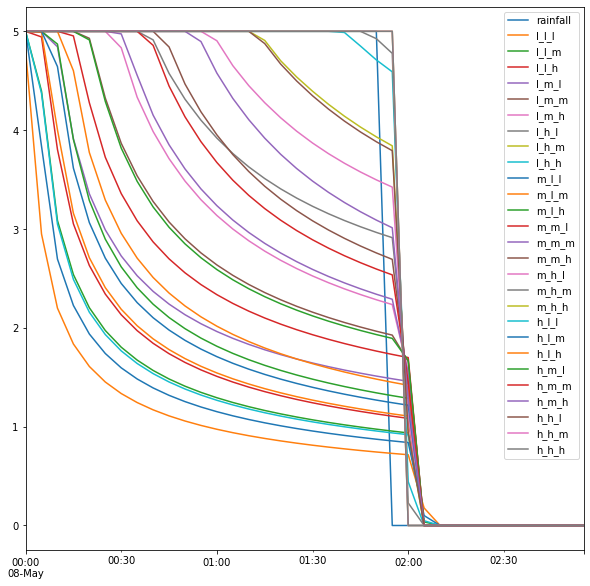

,rainfall,l_l_l,l_l_m,l_l_h,l_m_l,l_m_m,l_m_h,l_h_l,l_h_m,l_h_h,...,m_h_h,h_l_l,h_l_m,h_l_h,h_m_l,h_m_m,h_m_h,h_h_l,h_h_m,h_h_h
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,3.194444,0.907702,1.184386,1.363595,1.689938,2.139057,2.403036,2.753516,3.185234,3.321765,...,3.333333,1.166454,1.526703,1.755537,2.116243,2.632709,2.912868,3.174835,3.333333,3.333333
std,2.435681,0.957458,1.177646,1.305705,1.472166,1.728748,1.866713,2.022496,2.258205,2.358246,...,2.390457,1.169309,1.415580,1.550713,1.720267,1.983007,2.118118,2.252210,2.390457,2.390457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.822636,1.083400,1.258520,1.664173,2.188191,2.562317,3.271322,4.466072,5.000000,...,5.000000,1.062366,1.417785,1.661021,2.149802,2.937545,3.548372,4.422939,5.000000,5.000000
75%,5.000000,1.124272,1.503884,1.764466,2.272203,3.122656,3.779975,4.658948,5.000000,5.000000,...,5.000000,1.473261,2.008532,2.391209,3.068706,4.549179,5.000000,5.000000,5.000000,5.000000
max,5.000000,4.808551,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [2]:
tmp_folder = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\tmp"
tmp_name = 'green_ampt_tmp.inp'
out_folder = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out'
suction_list = [2.4, 3.5, 4.3]
k_list = [0.13,0.43, 1.18]
imd_list = [4.7, 8.5, 11.6]
dfs = sensitivity_analysis(tmp_folder, tmp_name, out_folder, suction_list, k_list, imd_list)
dfs.plot(figsize=(10, 10))
plt.show()
dfs.describe()

# Review the preliminary results

That looks a lot better than the one last week. We see more curves showing up. So let's check the low, medium and high results.

As shown below, I observed a few interesting things,

- when using high values, all the rainfall infiltrated.
- using low values, the infitration rate start to decrease almost immediately, and the rate of change decreases over time
- using the medium values, the infiltration rate is the same as the rainfall rate, and showed a similar pattern as the low values, and it felt like the shape is similar to the low values just with a shift

I don't know about other people, that's how I learn from the modeling results. Some of the observations are just interesting and are not going to lead anywhere, and some will help me  gain insights into the heart of the problem. Like I said, that's exactly how I did my graduate research. Try something, see what happens, learn a thing or two and make a guess, then try to confirm my guess.

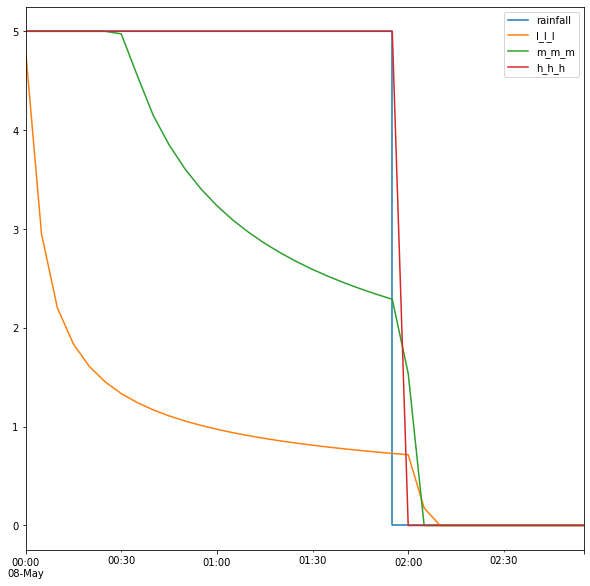

In [31]:
sub_dfs = dfs.loc[:, ['l_l_l', 'm_m_m', 'h_h_h', 'rainfall']]
rainfall = sub_dfs['rainfall']
del sub_dfs['rainfall']
ax = rainfall.plot(drawstyle="steps-post", label='rainfall')
sub_dfs.plot(ax=ax, figsize=(10,10))
plt.legend()

If I need to prove my theory is right or wrong, the most important thing is that I need to be able to measure it. So how do I measure my observations. When it comes to hydrographs, the following are typically used for calibrations, things that represent how a system works,

- area or volume
- peak values
- shape
- timing

Let's see what I shoud use to measure my findings,

- the area is a good one. that tells how much water the soil can absorb. In this case, total infiltration (in) = mean(time series)(in/hr) * simulation duration (hr)
- shape: I'll be interested to see the first order derivative, which describe how the curve decreases. I might dig deeper into it at another time.
- timing: I can see two things, when the infiltration rate is less than rainfall rate. And another is the knee of the curve, the time the curve start to turn flat

# Total Infiltration

This week I'll focus on the easy one. Total infiltration or the volume.

We have 5in/hr for the first 2 hours, and the total is 10in of rainfall. If we do a mean, we lost the last time step volume. I am not going to figure out how to calculate that directly from the results, let's just ignore the rainfall calculation below.


In [4]:
duration = 3 # hr, the simulation time
infiltrated_vol = dfs.mean().to_frame('vol')*duration
print(infiltrated_vol)

                vol
rainfall   9.583333
l_l_l      2.723107
l_l_m      3.553157
l_l_h      4.090786
l_m_l      5.069813
l_m_m      6.417171
l_m_h      7.209107
l_h_l      8.260548
l_h_m      9.555702
l_h_h      9.965295
m_l_l      3.199718
m_l_m      4.184232
m_l_h      4.816740
m_m_l      5.873148
m_m_m      7.353806
m_m_h      8.196045
m_h_l      9.108612
m_h_m      9.994240
m_h_h     10.000000
h_l_l      3.499361
h_l_m      4.580109
h_l_h      5.266612
h_m_l      6.348729
h_m_m      7.898128
h_m_h      8.738604
h_h_l      9.524506
h_h_m     10.000000
h_h_h     10.000000


# Results Table
Next I'll need to add all the green ampt parameters to the results above.

In [5]:
# build the parameters

labels = ['l', 'm', 'h']
rows = []
idx = []
i = 0
for sl, s in zip(labels, suction_list):
    for kl, k in zip(labels, k_list):
        for imdl, imd in zip(labels, imd_list):
            data = {'suction': s, 'ksat': k, 'imd': imd}
            run_id = '%s_%s_%s' % (sl, kl, imdl)
            rows.append(data)
            idx.append(run_id)
param_table = pd.DataFrame(rows, index=idx)

In [6]:
param_table = param_table.join(infiltrated_vol)
param_table

,imd,ksat,suction,vol
l_l_l,4.7,0.13,2.4,2.723107
l_l_m,8.5,0.13,2.4,3.553157
l_l_h,11.6,0.13,2.4,4.090786
l_m_l,4.7,0.43,2.4,5.069813
l_m_m,8.5,0.43,2.4,6.417171
l_m_h,11.6,0.43,2.4,7.209107
l_h_l,4.7,1.18,2.4,8.260548
l_h_m,8.5,1.18,2.4,9.555702
l_h_h,11.6,1.18,2.4,9.965295
m_l_l,4.7,0.13,3.5,3.199718


# Visualize Complicated Relationships

In this analysis, we would like to learn how the 3 input parameters explain the total infiltration volume. So we need to show 4 parameters in one plot, and we'll use the great [seaborn ](https://seaborn.pydata.org/) plotting package, which has some nice plots we can use.

You can install it by opening the anaconda prompt,

```
pip install seaborn
```


As shown below in the scatter plot, I use the color (hue) and the symbols (style) to represent two more parameters in the scatter plot. With such tricks, we can analyze 4 variables in one scattr plot!



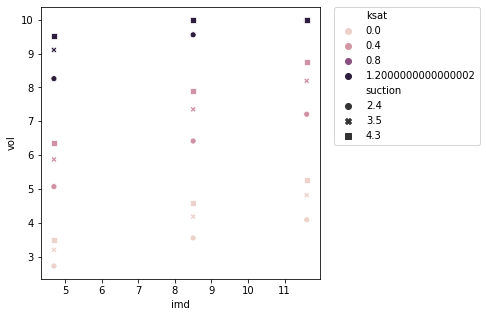

In [39]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.scatterplot(x="imd", y="vol",
                     hue="ksat", style="suction", data=param_table)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Reading a Plot
What a beautiful plot!

Below is our list of parameters.

```python
suction_list = [2.4, 3.5, 4.3]
k_list = [0.13,0.43, 1.18]
imd_list = [4.7, 8.5, 11.6]
```

Let's look at the x-axis, we can see all the dots are lined up along the 3 imd values, 4.7, 8.5 and 11.6. And immediately we can tell there is a general upward trend for all the dots.

And if I look closely by matching the color and style, I can draw lines connecting the dots, and for each line, the only thing that is different is the imd values. So let's plot that.

For example,
 - suction = low, ksat=low: we have a line l(ll) -> m(ll)->h(ll)


l_l 3.4556835698377752
l_m 6.23203045460913
l_h 9.260514880220095
m_l 4.066896765389376
m_m 7.141000002622604
m_h 9.700950937966505
h_l 4.448693960180713
h_m 7.6618205242686805
h_h 9.841501966118813


(3, 13)

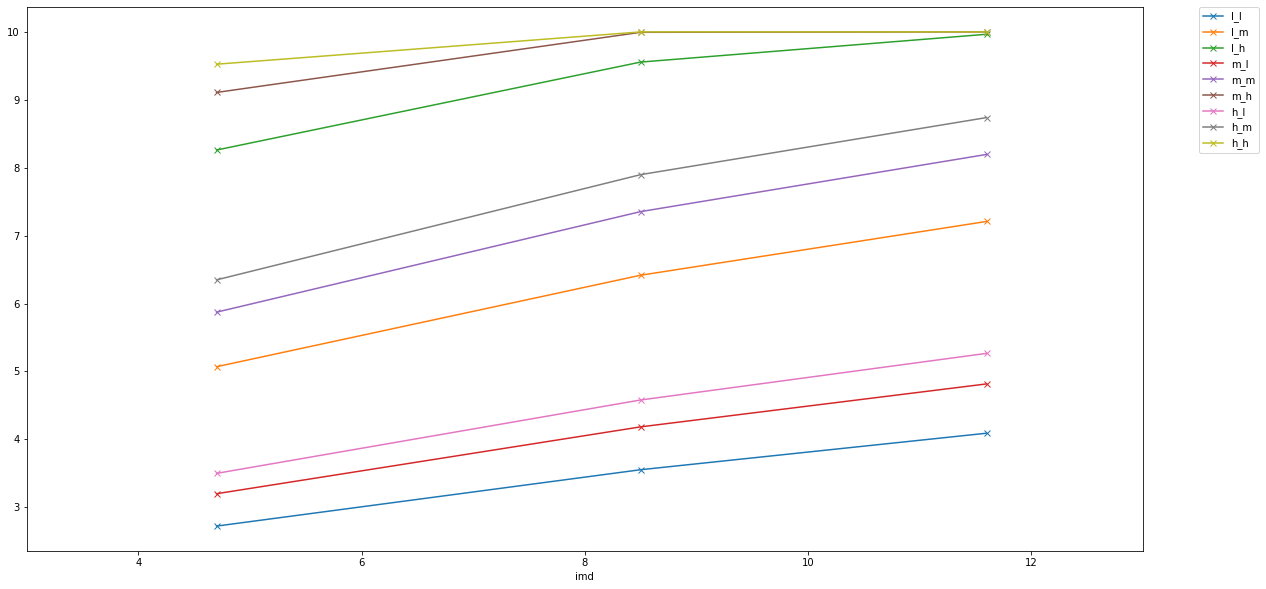

In [32]:
ax = None

for sk in ['l_l', 'l_m', 'l_h', 'm_l', 'm_m', 'm_h', 'h_l', 'h_m', 'h_h']:
    tests = ['%s_%s' % (sk, imdl) for imdl in ['l', 'm', 'h']]
    df = param_table.loc[tests, ]
    print(sk, df.vol.mean())

#     print(df.describe())
    if ax is None:
        ax = df.plot(x='imd', y='vol', label=sk, style='x-', figsize=(20,10))
    else:
        df.plot(x='imd', y='vol', ax=ax, label=sk, style='x-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(3, 13)

# First observation

Here are my first observations,

- It is very clear, as imd increase the total infiltration increases. And it feels like the slope of these lines are similar. In other words, it acts more like a factor than an abslute value.

- By comparing the average volume of each line (in the printed value above), which has the same suction and ksat, there is no obvious order to it. So one parameter is not dominating another parameter.

To be honest, for most of the modeling work I do, this kind of understanding probably is more than enough to get by most of the modeling tasks.

If you are interested, see what you can get out of the plots for ksat and suction.

l_l 3.1407289520526924
l_m 4.105832819206019
l_h 4.724712524149154
m_l 5.76389686928855
m_m 7.22303525937928
m_h 8.047918852832582
h_l 8.964555493659443
h_m 9.849980648193094
h_h 9.988431642452875


(2, 5)

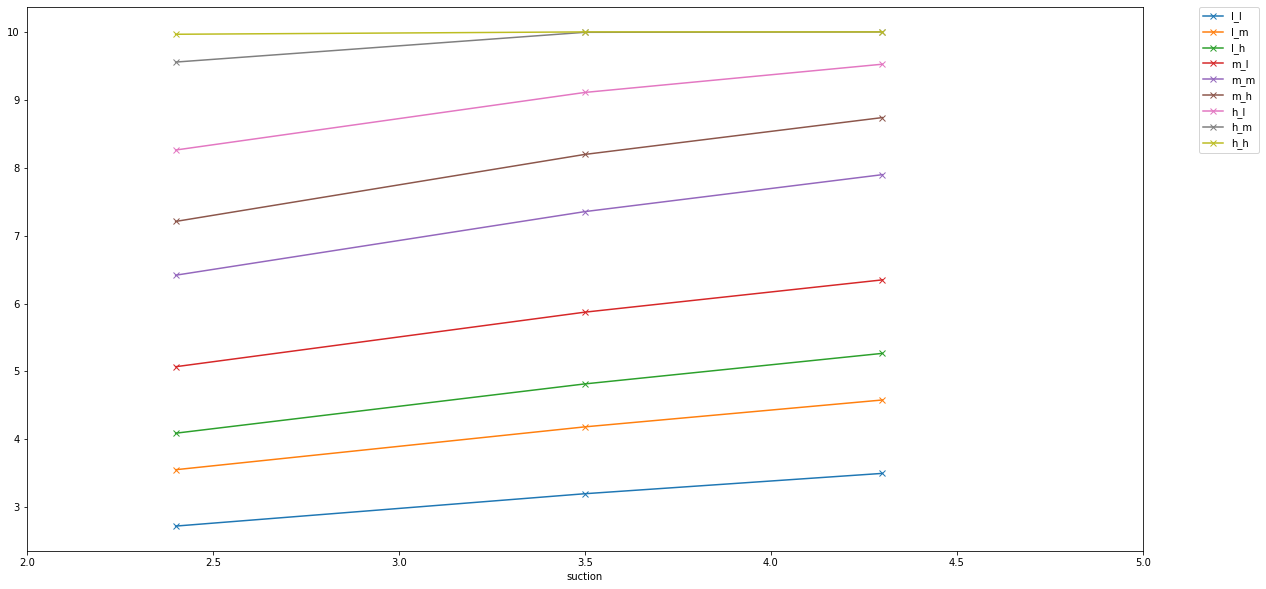

In [37]:
ax = None

for k_imd in ['l_l', 'l_m', 'l_h', 'm_l', 'm_m', 'm_h', 'h_l', 'h_m', 'h_h']:
    tests = ['%s_%s' % (s, k_imd) for s in ['l', 'm', 'h']]
    df = param_table.loc[tests, ]
    print(k_imd, df.vol.mean())

#     print(df.describe())
    if ax is None:
        ax = df.plot(x='suction', y='vol', label=k_imd, style='x-', figsize=(20,10))
    else:
        df.plot(x='suction', y='vol', ax=ax, label=k_imd, style='x-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(2, 5)

# Observation

Here are my first observations,

- It is very clear, as suction increase the total infiltration increases. And it feels like the slope of these lines are similar. In other words, it acts more like a factor than an abslute value.

- By comparing the average volume of each line (in the printed value above), which has the same imd and ksat, the order generally follows the combination. I guess ksat is more dominant than imd. Because a high imd with a low ksat is still smaller than a high sat with a low imd.